# Redes Lógicas Tensoriais com LTNTorch: Uma Introdução com Exemplos Práticos


## O que é uma Rede Lógica Tensorial (LTN)?
O LTN é um framework Neuro-Simbólico (NeSi) que combina efetivamente o poder do deep learning (Tensores) com o rigor do raciocínio
lógico (Lógica).

### A Ideia Central
Definir uma base de conhecimento lógico (KB)
e usá-la como a função objetivo (ou função de perda) para um modelo neural.

### Como isso é Possível?
Isso é possível usando lógica fuzzy, que relaxa os valores de verdade clássicos (Verdadeiro/Falso ou 1/0)
para um intervalo contínuo $[0, 1]$.

Isso torna as operações lógicas diferenciáveis, permitindo o aprendizado através da otimização padrão de
gradient descent (descida de gradiente).


### O Conceito Fundamental: Lógica Real (Real Logic)
LTN é baseado em uma linguagem formal chamada "Lógica Real" (Real Logic).

- Domínios: São interpretados como Tensores no corpo dos números reais $\mathbb{R}^n$ (incluindo escalares, vetores, matrizes, etc.).
- "Aterramento" (Grounding, $\mathcal{G}$): Este é o termo do LTN para a "interpretação" da lógica. Ele mapeia símbolos lógicos para tensores e funções diferenciáveis:
    - Constantes (ex: 'a', 'b') $\rightarrow$ Tensores (ex: vetores de embedding em $\mathbb{R}^d$).
    - Predicados (ex: 'P(x)') $\rightarrow$ Funções Diferenciáveis (ex: uma rede neural) que mapeiam tensores para um valor de verdade em $[0, 1]$.Ex: $P: \mathbb{R}^d \rightarrow [0, 1]$
    - Funções (ex: 'f(x)') $\rightarrow$ Funções Diferenciáveis (ex: uma rede neural) que mapeiam tensores para outros tensores.Ex: $f: \mathbb{R}^d \rightarrow \mathbb{R}^m$

## Tornando a Lógica Diferenciável: Operadores Fuzzy

Para que o backpropagation funcione, precisamos substituir os operadores lógicos clássicos ($\land, \lor, \lnot, \forall, \exists, \implies$) por versões "fuzzy" que sejam diferenciáveis.

Conectivos (t-normas, t-conormas)
* Conjunção ($\land$): t-norma do produto:$\mathcal{A}_{\land}(u, v) = u \cdot v$
* Disjunção ($\lor$): t-conorma do produto:$\mathcal{A}_{\lor}(u, v) = u + v - u \cdot v$
* Negação ($\lnot$): Negação padrão:$\mathcal{A}_{\lnot}(u) = 1 - u$
* Implicação ($\implies$): Implicação de Reichenbach:$\mathcal{A}_{\implies}(u, v) = 1 - u + u \cdot v$

Quantificadores (Agregadores)
- Universal ($\forall x$): Média generalizada (p-mean error):$\mathcal{A}_{\forall}(u_1, ..., u_n) = 1 - \left(\frac{1}{n}\sum_{i=1}^{n}(1-u_{i})^{p}\right)^{\frac{1}{p}}$
- Existencial ($\exists x$): Média generalizada (p-mean):$\mathcal{A}_{\exists}(u_1, ..., u_n) = \left(\frac{1}{n}\sum_{i=1}^{n}u_{i}^{p}\right)^{\frac{1}{p}}$

Ponto Chave: Todas estas operações são diferenciáveis, permitindo-nos propagar gradientes através de fórmulas lógicas complexas.
    

O Framework LTNtorch

LTNtorch é a implementação prática desses conceitos em PyTorch. Ele fornece os blocos de construção fundamentais:
- ltn.Constant: Um tensor que representa uma constante lógica (ex: um embedding fixo).
- ltn.Variable: Um tensor para variáveis (ex: 'x', 'y') que serão usadas em quantificadores.
- ltn.Predicate: Um torch.nn.Module que retorna um valor em $[0, 1]$. É aqui que a rede neural "aprende".
- ltn.Function: Um torch.nn.Module que retorna um tensor.
- ltn.Connective: And, Or, Not, Implies.ltn.
- Quantifier: Forall, Exists.ltn.
- Aggregator: SatAgg (Agrega o nível de satisfação de todas as fórmulas na Base de Conhecimento).

O Processo de Aprendizado em 5 PassosO fluxo de trabalho para treinar um modelo LTN é o seguinte:

1. Definir a Base de Conhecimento (KB): Escreva seus axiomas (conhecimento prévio) usando os componentes do LTNtorch.
2. Aterramento (Grounding): Alimente os dados de treinamento (tensores PyTorch) nas ltn.Variable das fórmulas.
3. Avaliação: Calcule o nível de satisfação de toda a KB (um único valor em $[0, 1]$) usando SatAgg.
4. Cálculo da Perda (Loss): A perda é simplesmente $Loss = 1.0 - SatAgg(\text{KB})$. Nosso objetivo é minimizar essa perda, o que equivale a maximizar a satisfação da lógica.
5. Otimização: Use um otimizador padrão do PyTorch (como Adam) para fazer o backpropagate da perda e atualizar os parâmetros dos ltn.Predicate (as redes neurais).

## Tutorial Prático: Classificação de imagens de cães e gatos

Vamos aplicar os conceitos do LTN a um problema de classificação de imagens usando o dataset **CIFAR-10**.

Problema: Classificar imagens $32 \times 32$ pixels em duas classes: **Cachorro** (Positiva) e **Gato** (Negativa).

Configuração do LTN:
1.  **Predicado**: Precisamos de um predicado $Dog(x)$ que aprenda a pergunta: *"A imagem x contém um cachorro?"*. Usaremos uma **CNN** para isso.
2.  **Variáveis**: Precisamos de variáveis lógicas para agrupar nossos dados: $x_{dogs}$ para batch de imagens de cachorros e $x_{cats}$ para batch de imagens de gatos.
3.  **Base de Conhecimento (Axiomas)**:
    * **Axioma 1 (Positivo)**: Para todo cachorro, o predicado Dog deve ser verdadeiro.
        * $\forall x_{dogs} (Dog(x_{dogs}))$
    * **Axioma 2 (Negativo)**: Para todo gato, o predicado Dog deve ser falso, ou seja, $\neg Dog$ deve ser verdadeiro.
        * $\forall x_{cats} (\neg Dog(x_{cats}))$

In [1]:
#!pip install LTNtorch

In [2]:
# É necessário instalar essa biblioteca para conseguir baixar o conjunto de dados facilmente.
#!pip install torchvision

### Código: 1. Imports e definição do modelo (CNN)
Imports e definição do modelo.

Primeiro importamos as bibliotecas e definimos nossa rede neural (CNN).

No modelo, usamos normalização para estabilizar o treinamento e evitar que a rede fique parada em 0.5.

Também é usado a função de ativação sigmoid para garantir que a saída esteja no intervalo $[0, 1]$, representando graus de verdade.

In [3]:
import ltn
import ltn as ltntorch
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset

# Configura o LTNtorch para usar o dispositivo (GPU se disponível).
ltntorch.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {ltntorch.device}")

Usando dispositivo: cpu


In [4]:
class CNN(nn.Module):

    def __init__(self):
        
        super(CNN, self).__init__()
        
        # Conv 1 + normalização de batch.
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.bn1 = nn.BatchNorm2d(6)
        self.pool = nn.MaxPool2d(2, 2)
        
        # Conv 2 + normalização de batch.
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.bn2 = nn.BatchNorm2d(16)
        
        # Camada densa
        # 16 (mapas de features) x 5 (altura da imagem) x 5 (largura da imagem) = 400.
        self.fc1 = nn.Linear(400, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):

        # Aplica BN após a convolução e antes da ativação/pooling.
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        
        x = torch.flatten(x, 1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        out = self.sigmoid(x)
        return out

# Cria o modelo.
model = CNN().to(ltntorch.device)
print("Modelo CNN criado.")

Modelo CNN criado.


### Código: 2. Preparação dos dados (CIFAR-10)

Usamos o dataset **CIFAR-10**.

Realizamos o pré-processamento:
1.  **Filtro de Classes**: Selecionamos apenas os índices correspondentes a gatos (3) e cachorros (5).
2.  **Normalização**: Convertemos as imagens para tensores e normalizamos os pixels para o intervalo $[-1, 1]$, o que ajuda na convergência da rede.
3.  **DataLoaders separados**: Criamos um loader para gatos e outro para cães, que facilita a aplicação de axiomas específicos em grupos específicos de dados dentro do mesmo loop de treino.

In [5]:
batch_size = 32

In [6]:
# tRansforma as imagens para tensores (com valores entre 0 e 1), e normaliza o valor dos tensores para valores entre -1 e 1. 
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Baixar ou carrega o CIFAR-10, que é o conjunto de dados que estamos usando.
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

In [ ]:
# Função para construir um data set com base em um índex.
def get_class_subset(dataset, class_index):

    indices = [i for i, label in enumerate(dataset.targets) if label == class_index]

    return Subset(dataset, indices)

# Criar datasets de treino separados: 3 = gato e 5 = cachorro.
cats_train = get_class_subset(trainset, 3)
dogs_train = get_class_subset(trainset, 5)

In [ ]:
# Criar DataLoaders separados, permitindo que a gente pegue um batch de gatos e um de cachorros simultaneamente.
loader_cats = DataLoader(cats_train, batch_size=batch_size, shuffle=True)
loader_dogs = DataLoader(dogs_train, batch_size=batch_size, shuffle=True)

print(f"Dados Carregados: {len(cats_train)} Gatos e {len(dogs_train)} Cachorros para treino.")

Dados Carregados: 5000 Gatos e 5000 Cachorros para treino.


--- Análise Quantitativa ---
Total de Gatos: 5000
Total de Cachorros: 5000
--- Análise Técnica ---
Formato do Tensor (Canais, Altura, Largura): torch.Size([3, 32, 32])
Tipo de dado: torch.float32
Valor Mínimo do Pixel (normalizado): -0.91
Valor Máximo do Pixel (normalizado): 0.71

--- Visualização ---


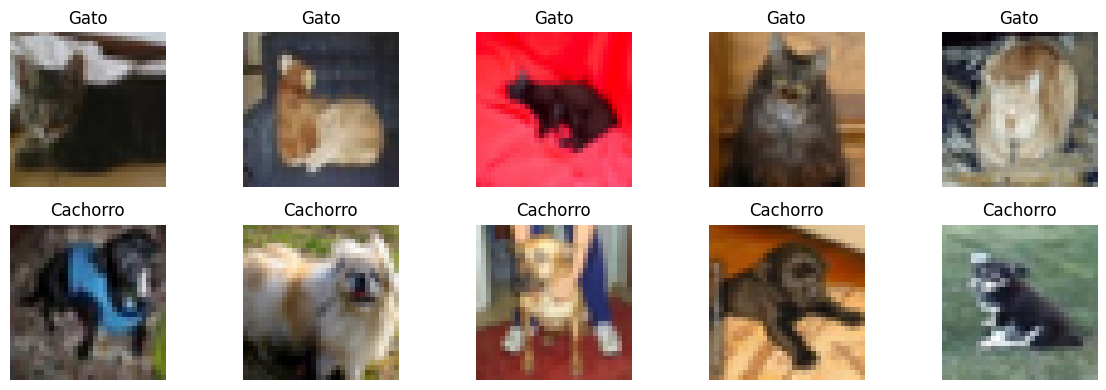

In [ ]:
# Célula para visualizar estatísticas e exemplos contidos nos conjuntos de treino.

# Função auxiliar para desnormalizar a imagem para visualização, 
# restaurando os valores de cada pixel para o intervalo [0.0 - 1.0], 
# e colocando as dimensões de volta para altura, largura e cor. 
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

# Análise de Quantidade.
print(f"--- Análise Quantitativa ---")
print(f"Total de Gatos: {len(cats_train)}")
print(f"Total de Cachorros: {len(dogs_train)}")

# Análise de Dimensões.
sample_img, sample_label = cats_train[0]
print(f"--- Análise Técnica ---")
print(f"Formato do Tensor (Canais, Altura, Largura): {sample_img.shape}")
print(f"Tipo de dado: {sample_img.dtype}")
print(f"Valor Mínimo do Pixel (normalizado): {sample_img.min():.2f}")
print(f"Valor Máximo do Pixel (normalizado): {sample_img.max():.2f}\n")

# Visualização dos Dados.
print(f"--- Visualização ---")
fig = plt.figure(figsize=(12, 4))

# Mostra 5 gatos.
for i in range(5):
    ax = fig.add_subplot(2, 5, i+1)
    img, label = cats_train[i]
    imshow(img)
    ax.set_title("Gato")

# mOstra 5 cachorros.
for i in range(5):
    ax = fig.add_subplot(2, 5, i+6)
    img, label = dogs_train[i]
    imshow(img)
    ax.set_title("Cachorro")

plt.tight_layout()
plt.show()

### Código: 3. Definição da lógica LTN

Agora, instanciamos os componentes lógicos do LTNtorch.

- **Predicado (Dog)**: "Embrulha" nossa CNN. Quando chamamos Dog(imagem), a rede processa a imagem e retorna o grau de verdade de ser um cachorro.
- **Operadores**: Reaproveitamos as definições dos operadores como o Not (negação), And (E), etc.
- **Quantificadores**: Reaproveitamos as definições dos quantificadores como o Forall ($\forall$) e o Exists ($\exists$).
- **Agregador de satisfação (sat_agg)**: É o operador responsável por combinar a "verdade" de todos os axiomas calculando um valor único que representa o quanto o modelo está obedecendo a todas as regras da base de conhecimento ao mesmo tempo.
- **Otimizador**: Usamos o Adam para ajustar os pesos da CNN baseando-se na satisfação lógica.

In [10]:
# Define o predicado
Dog = ltn.Predicate(model)

# Define operadores lógicos
Not = ltn.Connective(ltn.fuzzy_ops.NotStandard())
And = ltn.Connective(ltn.fuzzy_ops.AndProd())
Or = ltn.Connective(ltn.fuzzy_ops.OrProbSum())
Implies = ltn.Connective(ltn.fuzzy_ops.ImpliesReichenbach())
Forall = ltn.Quantifier(ltn.fuzzy_ops.AggregPMeanError(p=1), quantifier="f")
Exists = ltn.Quantifier(ltn.fuzzy_ops.AggregPMean(p=2), quantifier="e")

# Define o agregador de satisfação, pra calcular a satisfação total da KB
sat_agg = ltn.fuzzy_ops.SatAgg()

# Otimizador padrão do PyTorch
optimizer = torch.optim.Adam(Dog.parameters(), lr=0.001)

### Código: 4. O Loop de Treinamento

Este é o núcleo do LTN, adaptado para a classificação de imagens de cães e gatos.

1.  **Aterramento (Grounding):** Iteramos simultaneamente sobre os DataLoaders de cães e gatos usando zip e transformamos os tensores de imagens em ltn.Variable separadas, var_dogs e var_cats.
2.  **Formulação dos Axiomas:** Definimos as regras da nossa Base de Conhecimento usando o predicado Dog e os operadores lógicos:
    - **Axioma 1:** $\forall x \in \text{Cães}: \text{Dog}(x)$ (Para toda imagem no batch de cães, o predicado "é cachorro" deve ser verdadeiro).
    - **Axioma 2:** $\forall x \in \text{Gatos}: \neg \text{Dog}(x)$ (Para toda imagem no batch de gatos, o predicado "é cachorro" deve ser falso).
3.  **Satisfação e Perda:** Agregamos a verdade de ambos os axiomas usando sat_agg. A perda é calculada como $Loss = 1.0 - \text{satisfação}$.
4.  **Otimização:** Executamos o backward() para ajustar os pesos da CNN e maximizar a satisfação lógica.
5.  **Monitoramento:** A cada 50 batches, imprimimos a satisfação média e as probabilidades brutas que a rede está atribuindo para cada classe para acompanharmos o progresso do modelo.

In [11]:
epochs = 10
print("--- Iniciando Treinamento LTN ---")

for epoch in range(epochs):
    
    # Serve para acompanhar o erro médio ao longo de uma época.
    running_loss = 0.0
    
    for i, ((batch_dogs, _), (batch_cats, _)) in enumerate(zip(loader_dogs, loader_cats)):
        
        # Manda as imagens para o local onde os calculos vão acontecer.
        batch_dogs = batch_dogs.to(ltntorch.device)
        batch_cats = batch_cats.to(ltntorch.device)
        
        optimizer.zero_grad()

        # Variáveis.
        var_dogs = ltn.Variable("dogs", batch_dogs)
        var_cats = ltn.Variable("cats", batch_cats)

        # Axiomas.
        axiom_1 = Forall(var_dogs, Dog(var_dogs))
        axiom_2 = Forall(var_cats, Not(Dog(var_cats)))

        # Agregador de satisfação.
        sat = sat_agg(axiom_1, axiom_2)
        loss = 1. - sat
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if i % 50 == 0:

            with torch.no_grad():

                # Verifica a média de probabilidade que a rede dá para cães e gatos.
                # Cães deve subir para perto de 1.0, gatos deve descer para perto de 0.0.
                mean_pred_dog = Dog(var_dogs).value.mean().item()
                mean_pred_cat = Dog(var_cats).value.mean().item()
                
            print(f"Época {epoch+1:02d} | Batch {i:03d} | Sat: {sat.item():.4f} | Cães(1): {mean_pred_dog:.2f} | Gatos(0): {mean_pred_cat:.2f}")

print("Fim do treino.")

--- Iniciando Treinamento LTN ---
Época 01 | Batch 000 | Sat: 0.4994 | Cães(1): 0.53 | Gatos(0): 0.50
Época 01 | Batch 050 | Sat: 0.6191 | Cães(1): 0.68 | Gatos(0): 0.43
Época 01 | Batch 100 | Sat: 0.5313 | Cães(1): 0.61 | Gatos(0): 0.50
Época 01 | Batch 150 | Sat: 0.6875 | Cães(1): 0.77 | Gatos(0): 0.37
Época 02 | Batch 000 | Sat: 0.6148 | Cães(1): 0.68 | Gatos(0): 0.39
Época 02 | Batch 050 | Sat: 0.6968 | Cães(1): 0.85 | Gatos(0): 0.40
Época 02 | Batch 100 | Sat: 0.6846 | Cães(1): 0.64 | Gatos(0): 0.26
Época 02 | Batch 150 | Sat: 0.6721 | Cães(1): 0.54 | Gatos(0): 0.14
Época 03 | Batch 000 | Sat: 0.8030 | Cães(1): 0.83 | Gatos(0): 0.21
Época 03 | Batch 050 | Sat: 0.5347 | Cães(1): 0.58 | Gatos(0): 0.49
Época 03 | Batch 100 | Sat: 0.7570 | Cães(1): 0.72 | Gatos(0): 0.09
Época 03 | Batch 150 | Sat: 0.8930 | Cães(1): 1.00 | Gatos(0): 0.12
Época 04 | Batch 000 | Sat: 0.6426 | Cães(1): 0.56 | Gatos(0): 0.18
Época 04 | Batch 050 | Sat: 0.6736 | Cães(1): 0.70 | Gatos(0): 0.08
Época 04 | Bat

### Código: 5. Avaliação e Métricas

Avaliamos o modelo calculando a acurácia no conjunto de teste que a rede nunca viu.

- **Critério:** Se o predicado Dog(x) retornar um valor $> 0.5$, classificamos como cachorro. Caso contrário, é gato.
- **Visualização:** Exibimos algumas imagens aleatórias do teste junto com o valor atribuído pelo modelo para inspecionar diretamente os erros e acertos.

In [ ]:
# Filtramos o testset original para pegar apenas gatos e cães.
test_idx_cats = [i for i, label in enumerate(testset.targets) if label == 3]
test_idx_dogs = [i for i, label in enumerate(testset.targets) if label == 5]

test_cats = torch.utils.data.Subset(testset, test_idx_cats)
test_dogs = torch.utils.data.Subset(testset, test_idx_dogs)

test_loader_cats = DataLoader(test_cats, batch_size=32, shuffle=False)
test_loader_dogs = DataLoader(test_dogs, batch_size=32, shuffle=False)

In [13]:
print(f"\n--- Iniciando Avaliação no Test Set ---")
print(f"Total Gatos: {len(test_cats)} | Total Cães: {len(test_dogs)}")

correct = 0
total = 0

with torch.no_grad():
    
    # Testar cães, esperamos predicado > 0.5.
    for imgs, _ in test_loader_dogs:

        imgs = imgs.to(ltntorch.device)
        preds = Dog(ltn.Variable("x", imgs)).value 
        
        correct += (preds > 0.5).sum().item()
        total += imgs.size(0)

    # Testar gatos, esperamos predicado < 0.5, ou seje, Not Dog.
    for imgs, _ in test_loader_cats:
        imgs = imgs.to(ltntorch.device)
        preds = Dog(ltn.Variable("x", imgs)).value
        
        correct += (preds <= 0.5).sum().item()
        total += imgs.size(0)

accuracy = 100 * correct / total
print(f"Acurácia Final: {accuracy:.2f}%")


--- Iniciando Avaliação no Test Set ---
Total Gatos: 1000 | Total Cães: 1000
Acurácia Final: 88.80%



--- Exemplos Visuais ---


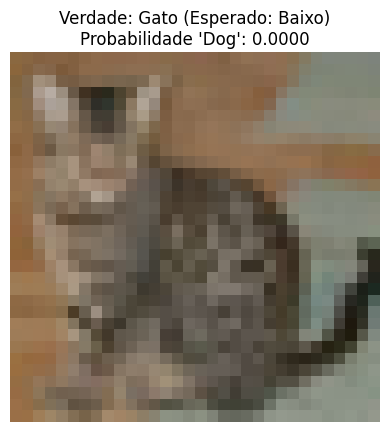

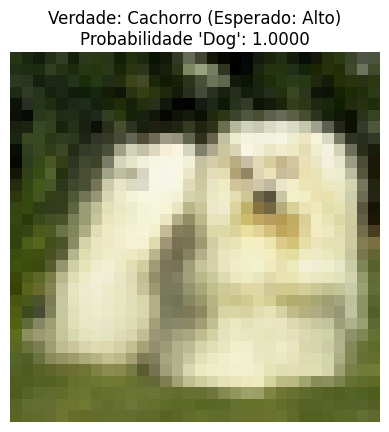

In [ ]:
# Função que recupera uma imagem aleatória de um conjunto de dados, calcula sua probabilidade de ser Dog e plota a imagem.
def visualize_prediction(dataset, label_name):
    idx = np.random.randint(len(dataset))
    img, _ = dataset[idx]
    
    # Classificação
    with torch.no_grad():
        score = Dog(ltn.Variable("x", img.unsqueeze(0).to(ltntorch.device))).value.item()
    
    # Plot
    img_np = img.numpy() / 2 + 0.5
    plt.imshow(np.transpose(img_np, (1, 2, 0)))
    plt.title(f"Verdade: {label_name}\nProbabilidade 'Dog': {score:.4f}")
    plt.axis('off')
    plt.show()

print("\n--- Exemplos Visuais ---")
visualize_prediction(test_cats, "Gato (Esperado: Baixo)")
visualize_prediction(test_dogs, "Cachorro (Esperado: Alto)")